In [4]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math

import datautils

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
num_classes = 11
feature_dim = datautils.FEATURE_DIM

In [20]:
print("Loading training data")
X_train, vectorizer, transformer = datautils.load_train_ngrams()
y_train = datautils.load_train_labels()
print("Loading dev data")
X_val, _, _ = datautils.load_dev_ngrams(vectorizer, transformer)
y_val = datautils.load_dev_labels()

Loading training data
Loading dev data


In [21]:
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

print("X_val:", X_val.shape)
print("y_val:", y_val.shape)

X_train: (11000, 13628)
y_train: (11000,)
X_val: (1100, 13628)
y_val: (1100,)


In [30]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, 13628])
y = tf.placeholder(tf.int64, [None])

lr = 1e-3
dr = 0.3

learning_rate = tf.placeholder(tf.float32)
dropout = tf.placeholder(tf.float32)
is_training = tf.placeholder(tf.bool)

fc1 = tf.layers.dense(X, 512, activation=tf.nn.relu)
bn1 = tf.layers.batch_normalization(fc1, training=is_training)
d1 = tf.layers.dropout(bn1, rate=dropout, training=is_training)
y_out = tf.layers.dense(d1, num_classes)

mean_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y, num_classes), logits=y_out))
optimizer = tf.train.AdamOptimizer(learning_rate)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

In [23]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch))):
            # generate indicies for the batch
            start_idx = (i*batch)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch]
            
            # get batch size
            actual_batch_size = yd[i:i+batch].shape[0]

            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx],
                         y: yd[idx],
                         is_training: training_now,
                         learning_rate: lr,
                         dropout: dr
                         }
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            iter_cnt += 1
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

In [35]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
train_losses = []
train_acc = []
val_losses = []
val_acc = []

In [ ]:
saver = tf.train.Saver()
saver.restore(sess, "gru-model-11")
with open("gru-model.txt") as logs:
    train_losses = [ float(val) for val in logs.readline().split() ]
    val_losses = [ float(val) for val in logs.readline().split() ]
    train_acc = [ float(val) for val in logs.readline().split() ]
    val_acc = [ float(val) for val in logs.readline().split() ]

Iteration 25: with minibatch training loss = 1.83 and accuracy of 0.32
Iteration 50: with minibatch training loss = 1.82 and accuracy of 0.4
Iteration 75: with minibatch training loss = 1.5 and accuracy of 0.44
Epoch 1, Overall loss = 1.77 and accuracy of 0.403


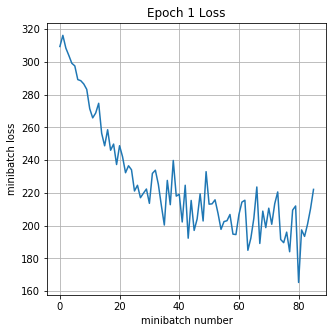

Epoch 1, Overall loss = 2.28 and accuracy of 0.335
Iteration 25: with minibatch training loss = 0.792 and accuracy of 0.83
Iteration 50: with minibatch training loss = 0.736 and accuracy of 0.8
Iteration 75: with minibatch training loss = 0.753 and accuracy of 0.76
Epoch 1, Overall loss = 0.735 and accuracy of 0.785


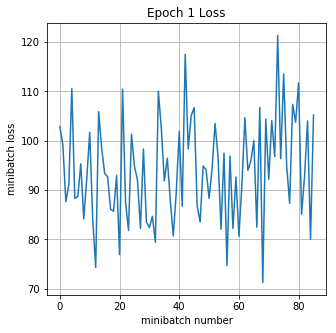

Epoch 1, Overall loss = 2.18 and accuracy of 0.364
Iteration 25: with minibatch training loss = 0.3 and accuracy of 0.92
Iteration 50: with minibatch training loss = 0.384 and accuracy of 0.88
Iteration 75: with minibatch training loss = 0.439 and accuracy of 0.89
Epoch 1, Overall loss = 0.333 and accuracy of 0.914


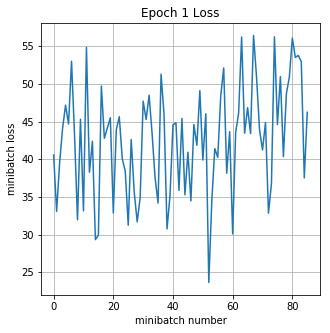

Epoch 1, Overall loss = 2.03 and accuracy of 0.424
Iteration 25: with minibatch training loss = 0.117 and accuracy of 1
Iteration 50: with minibatch training loss = 0.201 and accuracy of 0.95
Iteration 75: with minibatch training loss = 0.129 and accuracy of 0.98
Epoch 1, Overall loss = 0.165 and accuracy of 0.963


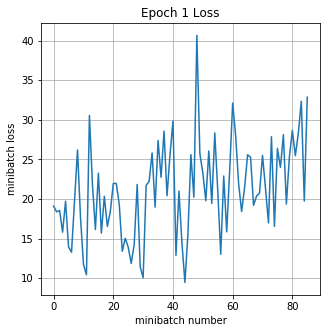

Epoch 1, Overall loss = 1.83 and accuracy of 0.455
Iteration 25: with minibatch training loss = 0.112 and accuracy of 0.98
Iteration 50: with minibatch training loss = 0.105 and accuracy of 0.98
Iteration 75: with minibatch training loss = 0.0439 and accuracy of 0.99
Epoch 1, Overall loss = 0.0915 and accuracy of 0.983


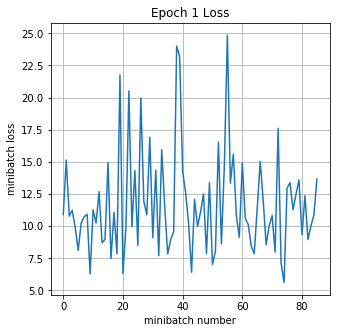

Epoch 1, Overall loss = 1.64 and accuracy of 0.46


In [36]:
epochs = 5
lr = 1e-3
dr = 0.5
for i in range(epochs):
    loss, acc = run_model(session=sess,
                          predict=y_out,
                          loss_val=mean_loss,
                          Xd=X_train,
                          yd=y_train,
                          epochs=1,
                          batch=128,
                          print_every=25,
                          training=train_step,
                          plot_losses=True)
    train_losses.append(loss)
    train_acc.append(acc)
    loss, acc = run_model(session=sess,
                          predict=y_out,
                          loss_val=mean_loss,
                          Xd=X_val,
                          yd=y_val,
                          epochs=1,
                          batch=X_val.shape[0],
                          print_every=1,
                          training=None,
                          plot_losses=False)
    val_losses.append(loss)
    val_acc.append(acc)

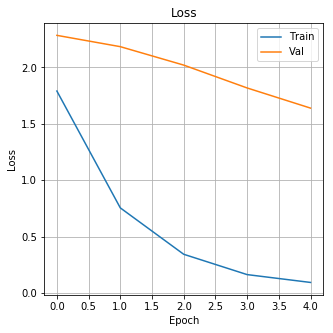

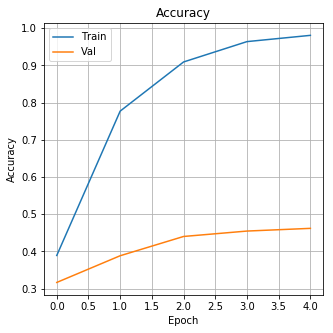

In [33]:
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.grid(True)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_acc, label='Train')
plt.plot(val_acc, label='Val')
plt.grid(True)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
f = open("gru-model.txt", 'w')
f.write(" ".join([str(num) for num in train_losses]) + "\n")
f.write(" ".join([str(num) for num in val_losses]) + "\n")
f.write(" ".join([str(num) for num in train_acc]) + "\n")
f.write(" ".join([str(num) for num in val_acc]) + "\n")
f.close()